In [45]:
import numpy as np
from numpy.linalg import inv
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, r2_score
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import math
import pickle

from fitter import Fitter, get_common_distributions, get_distributions

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('PS1D_train.csv')

In [3]:
data.drop(columns = ['Index'], inplace=True)
data.head()

,C1,C2,C3,C4,C5,C6,C7,C8,Target
0,1,0.665,0.500,0.175,1.2975,0.6075,0.3140,0.3150,9
1,2,0.535,0.460,0.145,0.7875,0.3395,0.2005,0.2000,8
2,1,0.625,0.495,0.155,1.0485,0.4870,0.2120,0.3215,11
3,2,0.625,0.490,0.110,1.1360,0.5265,0.1915,0.2925,9
4,3,0.410,0.300,0.090,0.2800,0.1410,0.0575,0.0750,8


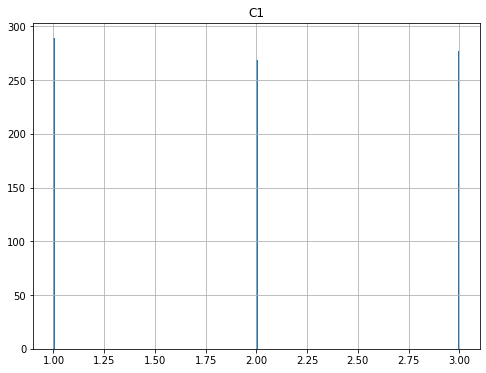

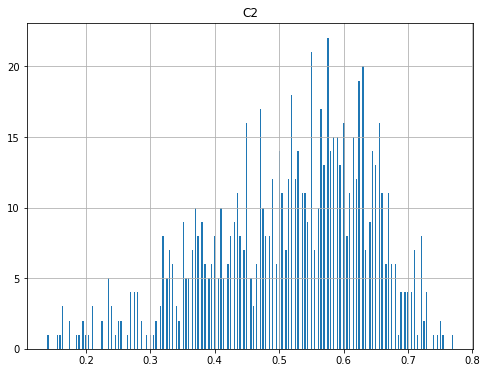

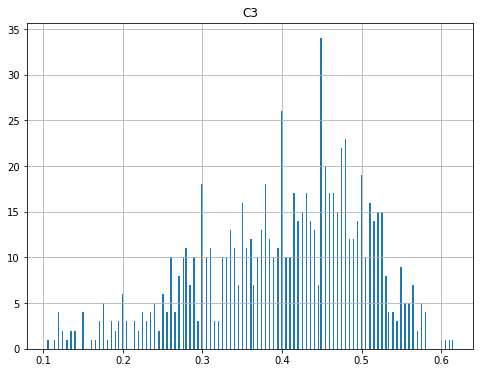

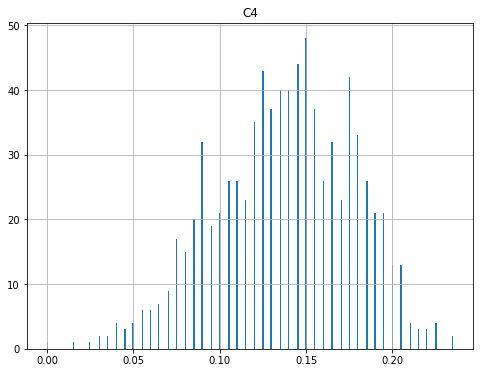

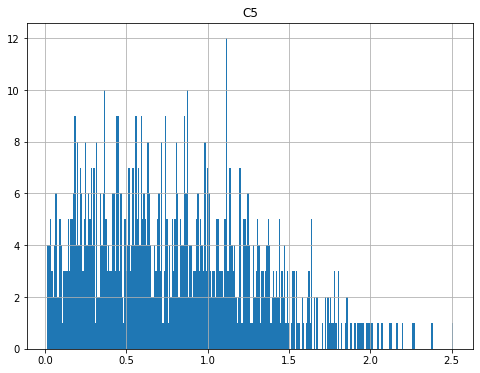

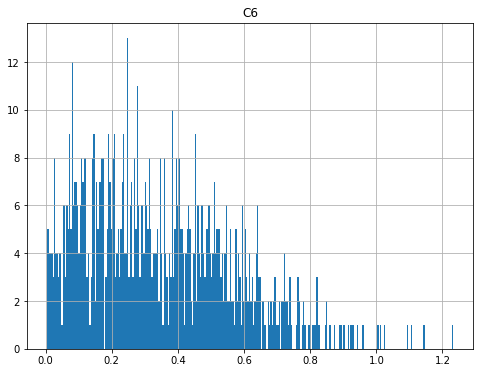

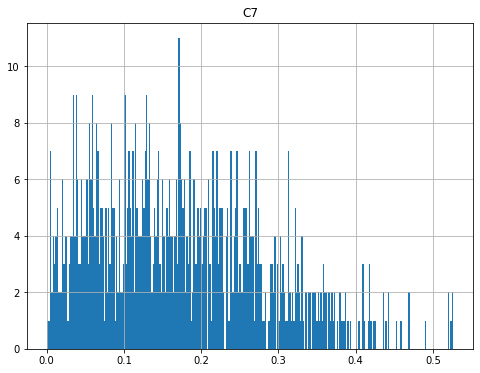

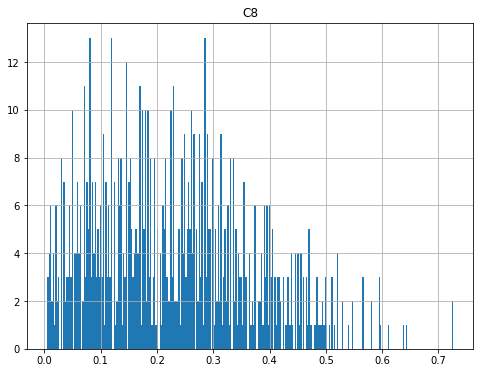

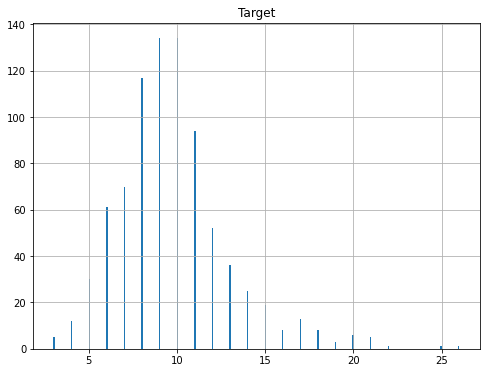

In [4]:
for i in list(data):
    data.hist(column=[i],bins=300, figsize=(8,6))

In [5]:
#sns.pairplot(data)

# New Approach

In [6]:
ndata = data.to_numpy()

# class separation & balancing

In [7]:
grouped = data.groupby('Target')

In [9]:
# df_1 = grouped.get_group(1)
# df_0 = grouped.get_group(0)

In [10]:
# ndf_1 = df_1.to_numpy()
# ndf_0 = df_0.to_numpy()

# model

In [11]:
def datagen(ndata, multiplier):
    l=[]

    for i in range((multiplier)*ndata.shape[0]):
        a = np.random.uniform(0,ndata.shape[0]-1,1)
        a = int(round(a[0],0))
        b = np.random.uniform(0,ndata.shape[0]-1,1)
        b = int(round(b[0],0))

        d = ndata[a] + np.random.uniform(0,1,1)*(ndata[b]-ndata[a])

        l.append(d)
    return np.array(l)

In [17]:
def balanced_gen(ndf_1,Total_size):
    a1 = datagen(ndf_1, int(Total_size/ndf_1.shape[0]))
    
    #temp1 = np.append(ndf_1, a1, axis = 0)
    #temp2 = np.append(ndf_0, a0, axis = 0)
    up_data = a1
    
    up_df = pd.DataFrame(up_data)
    up_df[8] = up_df[8].round(decimals = 0)
    up_df = up_df.astype({8: int})
    
    return(up_df.sample(frac = 1))

In [18]:
df_gen_temp = balanced_gen(ndata,5000)

In [19]:
df_gen_temp

,0,1,2,3,4,5,6,7,8
3159,3.000000,0.360143,0.271585,0.093862,0.270477,0.107706,0.052073,0.076360,6
1970,2.440360,0.454681,0.343305,0.107569,0.554010,0.235567,0.135988,0.152001,7
1047,2.182457,0.478763,0.364237,0.120658,0.670705,0.296415,0.144438,0.174817,7
4155,1.630113,0.544452,0.442807,0.159247,1.151724,0.427963,0.243010,0.244373,14
1577,1.000000,0.557197,0.446090,0.138328,0.738974,0.311914,0.174928,0.223861,9
...,...,...,...,...,...,...,...,...,...
880,2.000000,0.433036,0.342227,0.120708,0.406702,0.162013,0.099296,0.144801,7
3477,1.691474,0.490426,0.359256,0.118085,0.513088,0.212071,0.111437,0.156234,10
1224,2.710357,0.570655,0.451448,0.150930,0.825881,0.401630,0.152442,0.239482,10
2060,1.376108,0.527655,0.410730,0.136283,0.777669,0.394158,0.150354,0.204823,10


In [22]:
df_gen_temp2 = df_gen_temp.drop(columns=[8])

In [23]:
df_gen_temp2.shape

(4175, 8)

In [24]:
#noise = np.random.normal(0, 0.5, [df_gen_temp2.shape[0],df_gen_temp2.shape[1]])

In [25]:
mean_value = df_gen_temp.mean()
mean = mean_value.to_numpy()
#print(df_gen.shape[1])
for i in range(0, df_gen_temp.shape[1]):
    noise = np.random.normal(0, np.absolute(mean[i]) , [df_gen_temp.shape[0], df_gen_temp.shape[1]-1])

In [26]:
noise.shape

(4175, 8)

In [27]:
df_gen_temp3 = pd.DataFrame(noise+df_gen_temp2)

In [30]:
df_gen_temp3[8] = df_gen_temp[8]

In [31]:
df_gen = df_gen_temp3.copy()

In [32]:
df_gen.head()

,0,1,2,3,4,5,6,7,8
3159,-1.093392,-15.447054,2.657470,0.896589,-6.314566,-3.701890,3.695581,-1.240574,6
1970,8.255305,12.891870,-16.312880,-17.410403,35.651665,2.454590,1.947923,-9.233225,7
1047,-9.245936,8.566456,-7.932660,-0.661508,-1.897287,-0.868511,-16.350333,-3.234221,7
4155,-8.423567,-0.611633,0.860215,4.132925,1.517056,-5.106244,-10.221745,-8.690216,14
1577,-8.207245,-13.024090,4.851734,-0.281763,20.360561,-0.458727,-5.742023,-2.601539,9


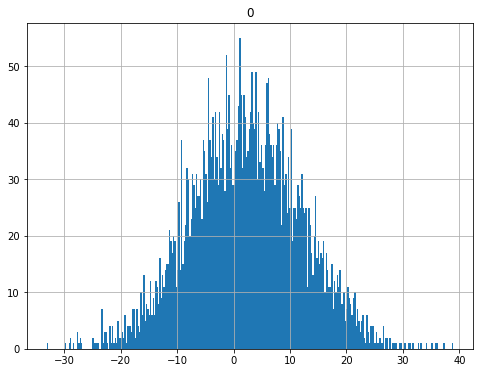

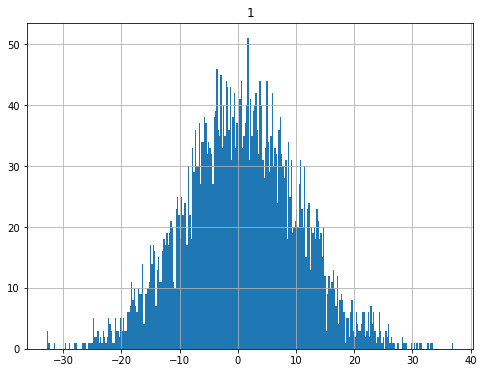

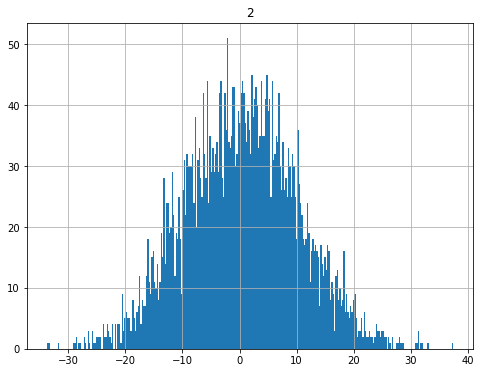

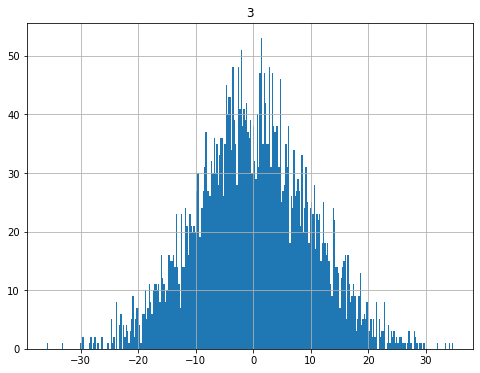

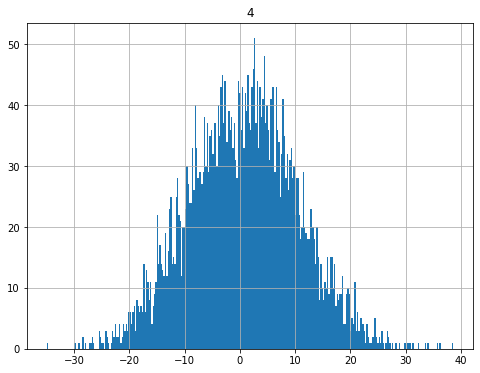

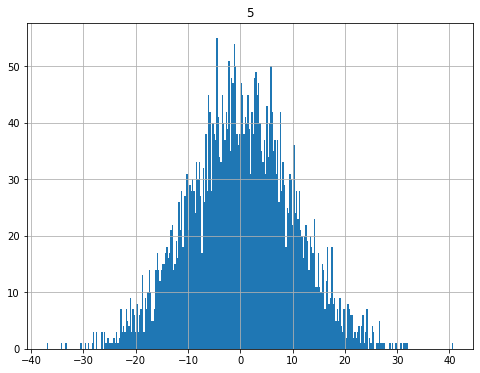

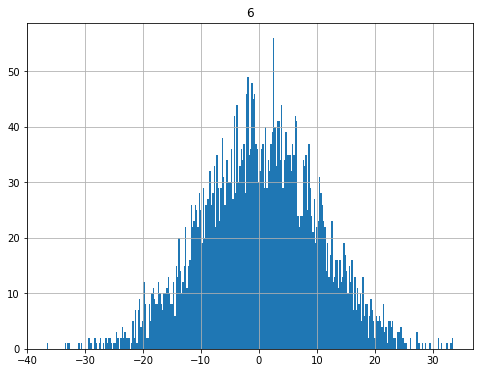

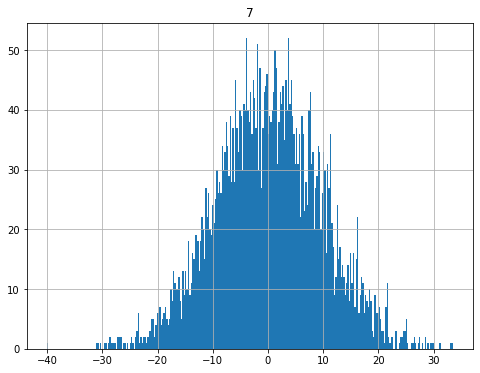

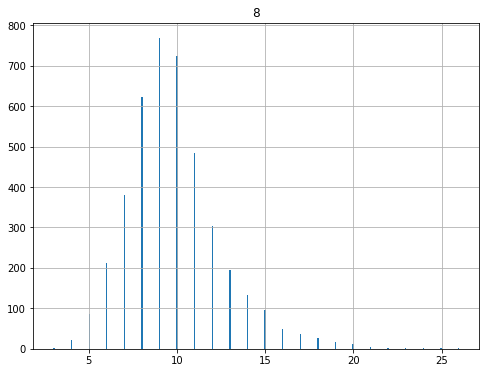

In [33]:
for i in list(df_gen):
    df_gen.hist(column=[i],bins=300, figsize=(8,6))

# Model (Neural Network)

In [75]:
#clf = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(1000, 10), random_state=1)

In [49]:
#df_gen

In [78]:
#clf.fit(df_gen.drop(columns=[29]),df_gen[29])

MLPClassifier(alpha=0.001, hidden_layer_sizes=(1000, 50), random_state=1,
              solver='lbfgs')

In [79]:
#y_pred = clf.predict(data.drop(columns=['Target']))

C:\Users\91979\anaconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [80]:
#m = confusion_matrix(data['Target'], y_pred)
#print(m)

[[980   0]
 [  0  20]]


In [81]:
#print('precision =',m[0][0]/(m[0][0]+m[0][1]))
#print('recall = ',m[0][0]/(m[0][0]+m[1][0]))

precision = 1.0
recall =  1.0


# XGBoost

In [47]:
model_1 = XGBClassifier(n_estimators=100,
                      learning_rate=0.05,
                      subsample=0.5,         
                      colsample_bytree=0.5,  
                      scale_pos_weight=1,
                      max_depth=3,
                      random_state=38)

In [50]:
model_1.fit(df_gen.drop(columns=[8]),df_gen[8]-3)

[08:11:48] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=3, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [51]:
# filename = 'model_1.sav'
# pickle.dump(model_1, open(filename, 'wb'))

In [53]:
y_pred1 = model_1.predict(pd.DataFrame(data.drop(columns=['Target']).to_numpy()))

m1 = confusion_matrix(data['Target'], y_pred1+3)
print(m1)

[[  0   0   0   0   0   0   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  30   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  61   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  68   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0 113   4   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0 128   6   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0 123  11   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  85   9   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  44   8   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [  0   0   0   0   0   0  32   4   0   0   0   0   0   0   0   0   0 

In [54]:
print('precision =',m1[0][0]/(m1[0][0]+m1[0][1]))
print('recall = ',m1[0][0]/(m1[0][0]+m1[1][0]))

precision = nan
recall =  nan


<ipython-input-54-9908ec785f74>:1: RuntimeWarning: invalid value encountered in longlong_scalars
  print('precision =',m1[0][0]/(m1[0][0]+m1[0][1]))
<ipython-input-54-9908ec785f74>:2: RuntimeWarning: invalid value encountered in longlong_scalars
  print('recall = ',m1[0][0]/(m1[0][0]+m1[1][0]))


# Submission

In [56]:
x = pd.read_csv('PS1D_test.csv')
x.drop(columns=['Index'], inplace = True)

In [57]:
y_pred1 = model_1.predict(pd.DataFrame(x.to_numpy()))+3

In [58]:
index = [i for i in range(1,len(y_pred1)+1)]

In [59]:
df = pd.DataFrame({'Index': index, 'Target': y_pred1})

In [60]:
df.to_csv("sub_D.csv",index=False)